In [1]:
import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging
import joblib
import time
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple

from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, log_loss, confusion_matrix, ConfusionMatrixDisplay

#Setting Up Parameters:
round_num = 3
num_clients = 20

model_name = "initial_model_datasample3.pkl"
test_data_name = "test_data_datasample3.pkl"

In [2]:
%%time
# Ensure all possible classes are included in each partial_fit call
all_classes = np.array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
                        'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 
                        'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator',
                        'Web Attack'])

# Set gRPC verbosity to debug (optional)
os.environ['GRPC_VERBOSITY'] = 'debug'

# Configure logging
logging.basicConfig(
    level=logging.INFO,  # Set the logging level (INFO, DEBUG, WARNING, etc.)
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Load the pre-trained model and test data
try:
    initial_model = joblib.load(model_name)
    X_test, y_test = joblib.load(test_data_name)
    logging.info("Model and test data loaded.")
except FileNotFoundError:
    logging.error("Pre-trained model or test data not found. Please ensure 'initial_model.pkl' and 'test_data.pkl' exist.")
    raise

# Function to extract model parameters
def get_model_parameters(model):
    return [param for param in model.coefs_] + [param for param in model.intercepts_]

# Function to set model parameters
def set_model_parameters(model, parameters):
    num_layers = len(model.coefs_)
    model.coefs_ = parameters[:num_layers]
    model.intercepts_ = parameters[num_layers:]

# Lists to store Client side metrics
client_side_losses = []
client_side_accuracies = []
learning_rates = []

server_side_losses = []
server_side_accuracies = []
server_side_precision_avr = []
server_side_precision_macro = []

# Define the evaluation function
def evaluate(server_round, parameters, config):
    if isinstance(parameters, fl.common.Parameters):
        parameters_ndarrays = parameters_to_ndarrays(parameters)
    else:
        parameters_ndarrays = parameters

    set_model_parameters(initial_model, parameters_ndarrays)
    server_side_losses = initial_model.loss_
    server_side_accuracies = initial_model.score(X_test, y_test)
    y_pred = initial_model.predict(X_test)
    server_side_precision_avr = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    server_side_precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    
    logging.info(f"Server Evaluation - Round {server_round}: Servers Loss = {server_side_losses }")
    logging.info(f"Server Evaluation - Round {server_round}: Servers Accuracy = {server_side_accuracies * 100:.2f}%")
    logging.info(f"Server Evaluation - Round {server_round}: Servers Precision Weighted = {server_side_precision_avr * 100:.2f}%")
    logging.info(f"Server Evaluation - Round {server_round}: Servers Precision Macro = {server_side_precision_macro * 100:.2f}%")
    return server_side_losses , {"accuracy": server_side_accuracies,
                                 "precision_avg":server_side_precision_avr,
                                 "precision_macro": server_side_precision_macro}

# Custom function to aggregate evaluation results
def weighted_average(results):
    accuracies = [r.metrics["accuracy"] * r.num_examples for _, r in results]
    examples = [r.num_examples for _, r in results]
    aggregated_accuracy = sum(accuracies) / sum(examples)
    
    # Assuming all clients return loss
    losses = [r.metrics["loss"] * r.num_examples for _, r in results]
    aggregated_loss = sum(losses) / sum(examples)
    
    return aggregated_loss, {"accuracy": aggregated_accuracy}

# Adaptive learning rate function decrease lr after 3 rounds with no improvement
def adaptive_learning_rate(round_number, initial_lr=0.00001, decay_factor=0.9, patience=3):
    if len(client_side_losses) > patience:
        recent_losses = client_side_losses[-patience:]
        if recent_losses[-1] >= min(recent_losses):
            return initial_lr * decay_factor
    return initial_lr

# create custom strategy class
class FedAvgWithCustomAggregation(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self, 
        server_round: int, 
        results: list, 
        failures: list
    ) -> tuple:
        if not results:
            return None, {}
        
        # Use the custom weighted average function to aggregate results
        aggregated_loss, aggregated_metrics = weighted_average(results)
        logging.info(f"Round {server_round} aggregated loss: {aggregated_loss}, aggregated accuracy: {aggregated_metrics['accuracy'] * 100:.2f}%")
        
        # Apply the aggregated parameters to the initial model
        aggregated_parameters = super().aggregate_fit(server_round, results, failures)[0]
        set_model_parameters(initial_model, parameters_to_ndarrays(aggregated_parameters))       
 
        # Append the Client side metrics for further analysis
        client_side_losses.append(aggregated_loss)
        client_side_accuracies.append(aggregated_metrics["accuracy"])
        
        # Append the Server side metrics for further analysis
        server_side_losses.append(initial_model.loss_)
        server_side_accuracies.append(initial_model.score(X_test, y_test))
        y_pred = initial_model.predict(X_test)
        server_side_precision_avr.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        server_side_precision_macro.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        
        # Adjust the learning rate
        current_lr = adaptive_learning_rate(server_round)
        learning_rates.append(current_lr)
        logging.info(f"Round {server_round} adjusted learning rate: {current_lr}")

        return aggregated_parameters, aggregated_metrics

    
# Convert initial model parameters to Flower Parameters object
initial_parameters = ndarrays_to_parameters(get_model_parameters(initial_model))

# Define the strategy using the custom stated above
strategy = FedAvgWithCustomAggregation(
    fraction_fit=1.0,
    fraction_evaluate=0.0,
    min_fit_clients=num_clients, 
    min_available_clients=num_clients,
    initial_parameters=initial_parameters,
    evaluate_fn=evaluate,
)

# Start the Flower server with the custom strategy and timeout
logging.info("Starting the Flower server...")
fl.server.start_server(
    server_address="127.0.0.1:8882",
    config=fl.server.ServerConfig(num_rounds=round_num, round_timeout=6000),  # 6000 seconds timeout
    strategy=strategy,
)
logging.info("Server has shut down.")

2024-09-04 03:26:30,729 - INFO - Model and test data loaded.
2024-09-04 03:26:30,731 - INFO - Starting the Flower server...
INFO :      Starting Flower server, config: num_rounds=3, round_timeout=6000s
2024-09-04 03:26:30,732 - INFO - Starting Flower server, config: num_rounds=3, round_timeout=6000s
INFO :      Flower ECE: gRPC server running (3 rounds), SSL is disabled
2024-09-04 03:26:30,767 - INFO - Flower ECE: gRPC server running (3 rounds), SSL is disabled
INFO :      [INIT]
2024-09-04 03:26:30,768 - INFO - [INIT]
INFO :      Using initial global parameters provided by strategy
2024-09-04 03:26:30,768 - INFO - Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
2024-09-04 03:26:30,768 - INFO - Starting evaluation of initial global parameters
2024-09-04 03:26:31,646 - INFO - Server Evaluation - Round 0: Servers Loss = 0.06288021932338779
2024-09-04 03:26:31,646 - INFO - Server Evaluation - Round 0: Servers Accuracy = 97.

INFO :      	              (2, 0.9789631855747558),
2024-09-04 03:28:55,219 - INFO - 	              (2, 0.9789631855747558),
INFO :      	              (3, 0.9791735537190083)],
2024-09-04 03:28:55,220 - INFO - 	              (3, 0.9791735537190083)],
INFO :      	 'precision_avg': [(0, 0.977410901108209),
2024-09-04 03:28:55,220 - INFO - 	 'precision_avg': [(0, 0.977410901108209),
INFO :      	                   (1, 0.9787111753461857),
2024-09-04 03:28:55,221 - INFO - 	                   (1, 0.9787111753461857),
INFO :      	                   (2, 0.9788016307562444),
2024-09-04 03:28:55,221 - INFO - 	                   (2, 0.9788016307562444),
INFO :      	                   (3, 0.9790058676342797)],
2024-09-04 03:28:55,222 - INFO - 	                   (3, 0.9790058676342797)],
INFO :      	 'precision_macro': [(0, 0.8748300520758735),
2024-09-04 03:28:55,222 - INFO - 	 'precision_macro': [(0, 0.8748300520758735),
INFO :      	                     (1, 0.8786811189805879),
2024-09-04

CPU times: total: 14.3 s
Wall time: 2min 24s


In [3]:
# #Storing metrics
# client_loss_5c_5e_5r = pd.DataFrame(client_side_losses, columns=["Loss"]) 
# client_loss_5c_5e_5r.to_pickle("client_loss_20c_5e_5r_datasample3.pkl")

# client_acc_5c_5e_5r = pd.DataFrame(client_side_accuracies, columns=["Accuracy"]) 
# client_acc_5c_5e_5r.to_pickle("client_acc_20c_5e_5r_datasample3.pkl")

# server_acc_5c_5e_5r = pd.DataFrame(server_side_accuracies, columns=["Accuracy"]) 
# server_acc_5c_5e_5r.to_pickle("server_acc_20c_5e_5r_datasample3.pkl")

# server_prec_5c_5e_5r = pd.DataFrame(server_side_precision_avr, columns=["Precision"]) 
# server_prec_5c_5e_5r.to_pickle("server_prec_20c_5e_5r_datasample3.pkl")

# server_prec_macro_5c_5e_5r = pd.DataFrame(server_side_precision_macro, columns=["Macro Precision"]) 
# server_prec_macro_5c_5e_5r.to_pickle("server_prec_macro_20c_5e_5r_datasample3.pkl")

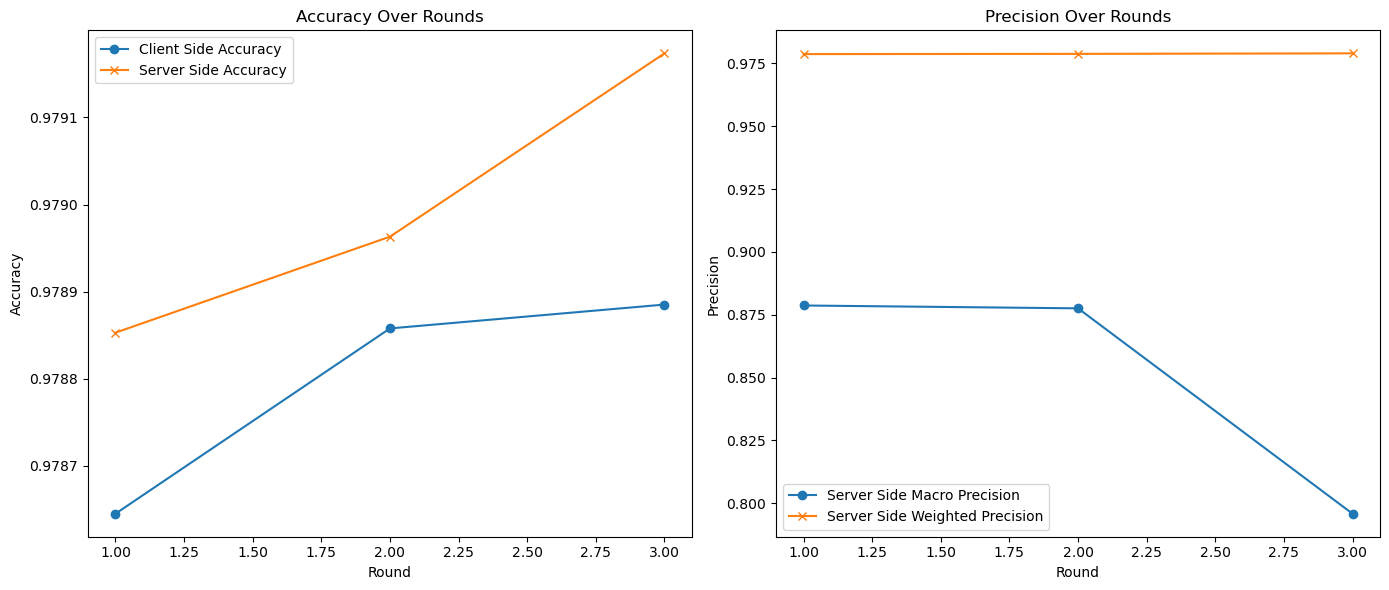

In [4]:
# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Client Side Accuracies and Server Side Accuracies
axs[0].plot(range(1, len(client_side_accuracies) + 1), client_side_accuracies, marker='o', label='Client Side Accuracy')
axs[0].plot(range(1, len(server_side_accuracies) + 1), server_side_accuracies, marker='x', label='Server Side Accuracy')
axs[0].set_title('Accuracy Over Rounds')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='best')

# Plot Server Side Macro Precision and Weighted Precision
axs[1].plot(range(1, len(server_side_precision_macro) + 1), server_side_precision_macro, marker='o', label='Server Side Macro Precision')
axs[1].plot(range(1, len(server_side_precision_avr) + 1), server_side_precision_avr, marker='x', label='Server Side Weighted Precision')
axs[1].set_title('Precision Over Rounds')
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Precision')
axs[1].legend(loc='best')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
# plt.savefig("Metrics_Comparison_FedAver.png", dpi=300, format="png")
plt.show()


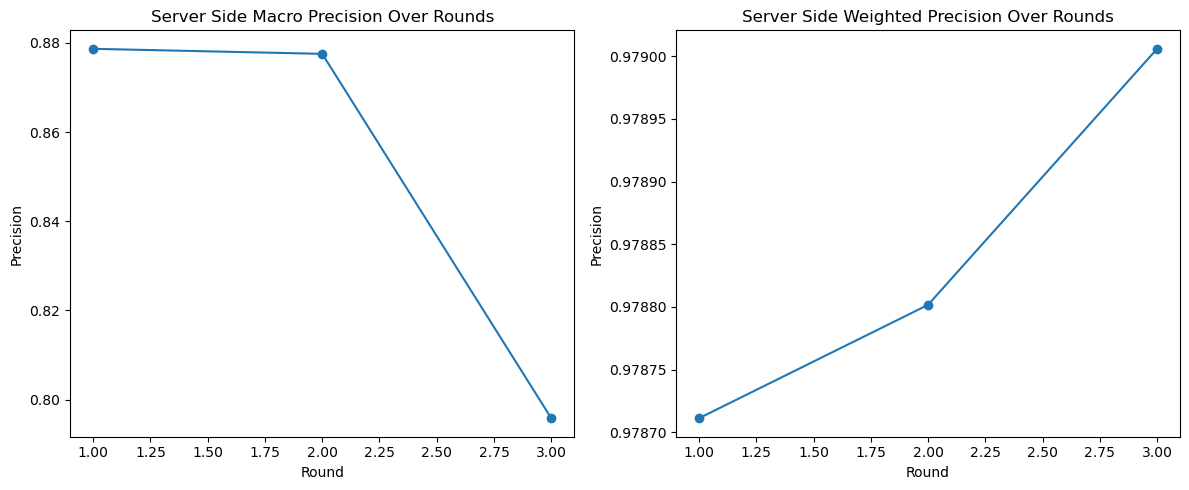

In [5]:
# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Server Side Macro Precision Over Rounds
axs[0].plot(range(1, len(server_side_precision_macro) + 1), server_side_precision_macro, marker='o')
axs[0].set_title('Server Side Macro Precision Over Rounds')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Precision')

# Plot Server Side Weighted Precision Over Rounds
axs[1].plot(range(1, len(server_side_precision_avr) + 1), server_side_precision_avr, marker='o')
axs[1].set_title('Server Side Weighted Precision Over Rounds')
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Precision')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
#plt.savefig("Accuracy_Comparison_FedAver_20.png", dpi=300, format ="png")
plt.show()

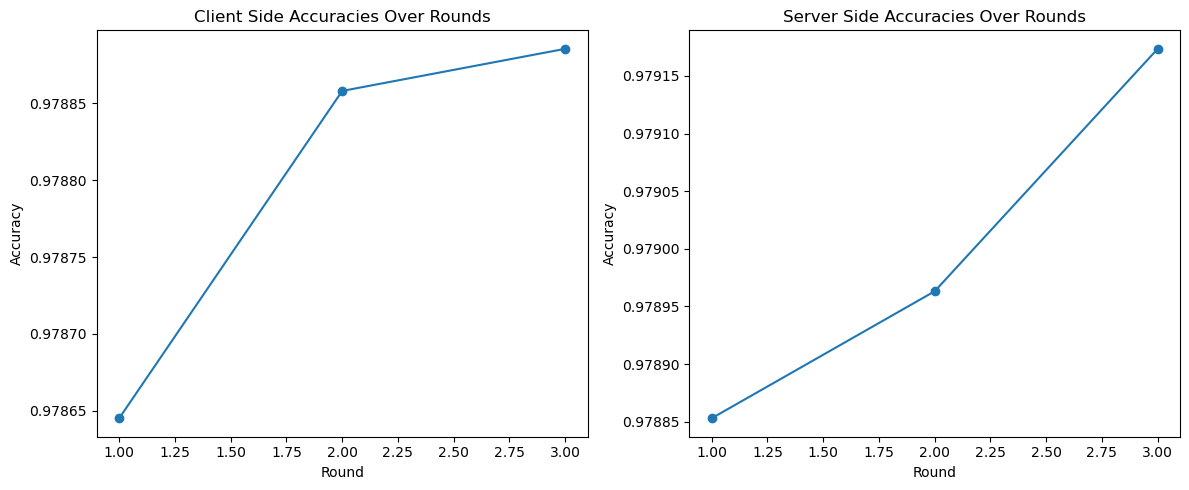

In [6]:
# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Client Side Accuracies
axs[0].plot(range(1, len(client_side_accuracies) + 1), client_side_accuracies, marker='o')
axs[0].set_title('Client Side Accuracies Over Rounds')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Accuracy')

# Plot Server Side Accuracies
axs[1].plot(range(1, len(server_side_accuracies) + 1), server_side_accuracies, marker='o')
axs[1].set_title('Server Side Accuracies Over Rounds')
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Accuracy')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
#plt.savefig("Accuracy_Comparison_FedAver_20.png", dpi=300, format ="png")
plt.show()

In [7]:
# calculate predictions 
y_pred = initial_model.predict(X_test)
y_prob = initial_model.predict_proba(X_test)
loss_log = log_loss(y_test, y_prob)
# Print classification report
print(classification_report(y_test, y_pred))

# Calculating and printing accuracy, precision, recall, F1-score. Setting "zero_division=1" for those classes where non of the instances where predicted correclty
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate loss, and rocauc
loss = initial_model.loss_
loss_log = log_loss(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

# Storing initial model's metrics for later
general_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Precision_macro': precision_macro, 
    'Recall': recall,
    'F1-Score': f1,
    'Loss': loss,
    'Logistic Loss': loss_log,
    'ROC AUC': roc_auc
}
general_metrics_df = pd.DataFrame([general_metrics]).T
general_metrics_df.columns = ["Values"]
#general_metrics_df.to_pickle("gen_met_20c_5r_5e_datasample3.pkl")
general_metrics_df

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

          BENIGN       0.98      1.00      0.99     82963
             Bot       0.73      0.35      0.47        77
            DDoS       1.00      0.98      0.99      5069
   DoS GoldenEye       0.96      0.98      0.97       408
        DoS Hulk       1.00      0.90      0.95      6846
DoS Slowhttptest       0.87      1.00      0.93       207
   DoS slowloris       0.91      0.75      0.82       213
     FTP-Patator       1.00      0.70      0.82       235
      Heartbleed       0.00      0.00      0.00         1
    Infiltration       0.00      0.00      0.00         2
        PortScan       0.91      0.83      0.87      3591
     SSH-Patator       0.99      0.86      0.92       128
      Web Attack       1.00      0.06      0.11        85

        accuracy                           0.98     99825
       macro avg       0.80      0.65      0.68     99825
    weighted avg       0.98      0.98      0.98     99825



Values
Accuracy         0.979174
Precision        0.979006
Precision_macro  0.795837
Recall           0.979174
F1-Score         0.978294
Loss             0.062880
Logistic Loss    0.054192
ROC AUC          0.962286

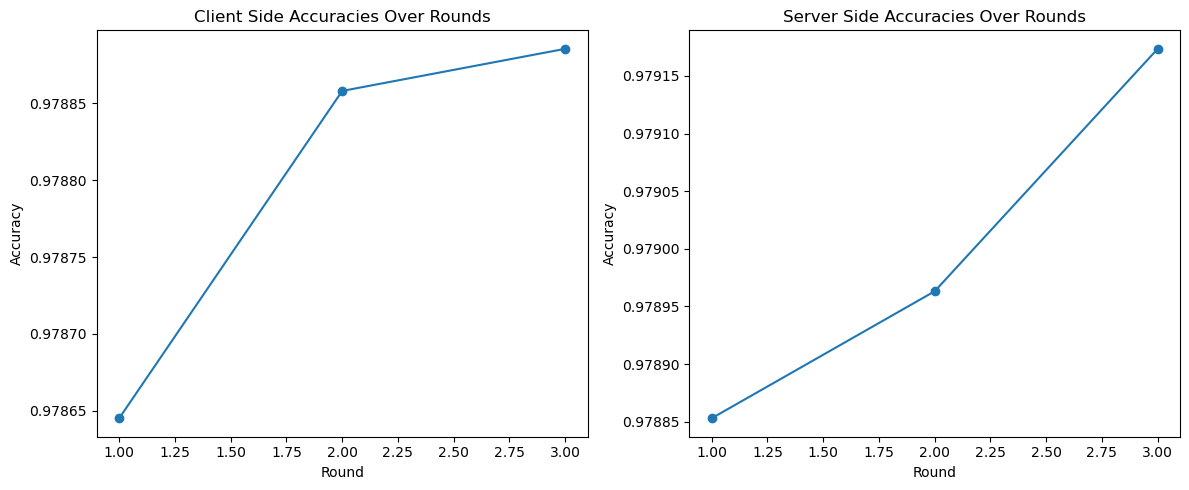

In [8]:
# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Client Side Accuracies
axs[0].plot(range(1, len(client_side_accuracies) + 1), client_side_accuracies, marker='o')
axs[0].set_title('Client Side Accuracies Over Rounds')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Accuracy')

# Plot Server Side Accuracies
axs[1].plot(range(1, len(server_side_accuracies) + 1), server_side_accuracies, marker='o')
axs[1].set_title('Server Side Accuracies Over Rounds')
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Accuracy')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
#plt.savefig("Accuracy_Comparison_FedAver2.png", dpi=300, format ="png")
plt.show()

In [9]:
learning_rates

[1e-05, 1e-05, 1e-05]

Text(0, 0.5, 'Loss')

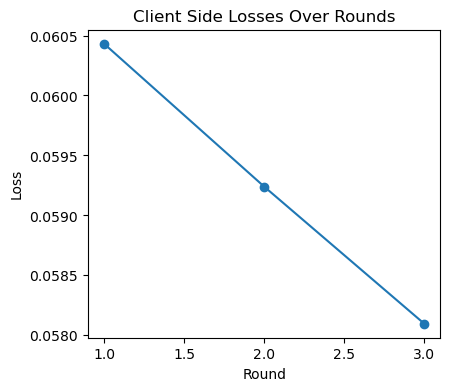

In [10]:
# Plotting the centralized losses and accuracies
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(client_side_losses) + 1), client_side_losses, marker='o')
plt.title('Client Side Losses Over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
#plt.savefig("Client_side_losses.png")

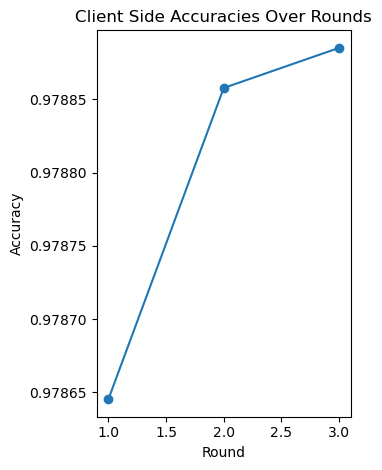

In [11]:
plt.subplot(1, 2, 2)
plt.plot(range(1, len(client_side_accuracies) + 1), client_side_accuracies, marker='o')
plt.title('Client Side Accuracies Over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')

plt.tight_layout()
#plt.savefig("Client_side.png", dpi=300)
plt.show()

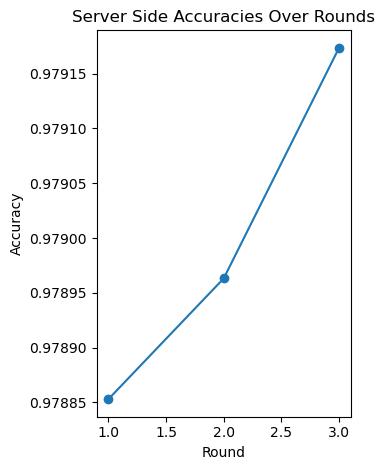

In [12]:
plt.subplot(1, 2, 2)
plt.plot(range(1, len(server_side_accuracies) + 1), server_side_accuracies, marker='o')
plt.title('Server Side Accuracies Over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')

plt.tight_layout()
#plt.savefig("Server_side.png", dpi=300)
plt.show()

In [13]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Initialize lists to store TPR and FPR for each class
tpr_list = []
fpr_list = []

tp_list = []
fp_list = []
tn_list = []
fn_list = []

# Calculate TPR and FPR for each class
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    # Avoid division by zero
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

    tpr_list.append(TPR)
    fpr_list.append(FPR)
    
    tp_list.append(TP)
    fp_list.append(FP)
    tn_list.append(TN)
    fn_list.append(FN)
    

# Convert lists to numpy arrays for easier manipulation if needed
tpr_array = np.array(tpr_list)
fpr_array = np.array(fpr_list)

tp_array = np.array(tp_list)
fp_array = np.array(fp_list)
tn_array = np.array(tn_list)
fn_array = np.array(fn_list)

# create attack classes metrics dataframe
attack_classes = ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 
                  'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 
                  'PortScan', 'SSH-Patator', 'Web Attack']

eval_metrics = pd.DataFrame({
    'Attack Class': attack_classes,
    'True Positive Rate (TPR)': tpr_list,
    'False Positive Rate (FPR)': fpr_list,
    'True Positive (TP)': tp_list,
    'False Positives (FP)': fp_list,
    'True Negatives (TN)': tn_list,
    'False Negatives (FN)': fn_list
})

# Set 'Attack Class' as the index
eval_metrics.set_index('Attack Class', inplace=True)
#eval_metrics.to_pickle("eval_met_20cars_5_epochs_5_rounds_datasample3.pkl") # Saving the evaluation metrics of initial model into separate files
eval_metrics

True Positive Rate (TPR)  False Positive Rate (FPR)  \
Attack Class                                                            
BENIGN                            0.995239                   0.099039   
Bot                               0.350649                   0.000100   
DDoS                              0.981061                   0.000211   
DoS GoldenEye                     0.982843                   0.000151   
DoS Hulk                          0.897897                   0.000161   
DoS Slowhttptest                  1.000000                   0.000311   
DoS slowloris                     0.751174                   0.000161   
FTP-Patator                       0.697872                   0.000000   
Heartbleed                        0.000000                   0.000000   
Infiltration                      0.000000                   0.000010   
PortScan                          0.830966                   0.003117   
SSH-Patator                       0.859375                   0.000010   
Web Attack                        0.058824                   0.000000   

                  True Positive (TP)  False Positives (FP)  \
Attack Class                                                 
BENIGN                         82568                  1670   
Bot                               27                    10   
DDoS                            4973                    20   
DoS GoldenEye                    401                    15   
DoS Hulk                        6147                    15   
DoS Slowhttptest                 207                    31   
DoS slowloris                    160                    16   
FTP-Patator                      164                     0   
Heartbleed                         0                     0   
Infiltration                       0                     1   
PortScan                        2984                   300   
SSH-Patator                      110                     1   
Web Attack                         5                     0   

                  True Negatives (TN)  False Negatives (FN)  
Attack Class                                                 
BENIGN                          15192                   395  
Bot                             99738                    50  
DDoS                            94736                    96  
DoS GoldenEye                   99402                     7  
DoS Hulk                        92964                   699  
DoS Slowhttptest                99587                     0  
DoS slowloris                   99596                    53  
FTP-Patator                     99590                    71  
Heartbleed                      99824                     1  
Infiltration                    99822                     2  
PortScan                        95934                   607  
SSH-Patator                     99696                    18  
Web Attack                      99740                    80

In [14]:
# Save the final model
#joblib.dump(initial_model, 'final_model_20cars_5epoch_5rounds_datasample3.pkl')